## **Using a Convolutional Neural Network to Identify Cube Rotations.**

In this notebook, I will be using images which I have generated using my Shape3D.py and GenerateData.py images, found at https://github.com/javidahmed64592/Y4-Nanoparticles-Project.

I will be using TensorFlow2 and Keras to create a Sequential model which will be trained using the cube images, and then more images will be tested to see if the model can correctly identify their rotations.

The tutorial I followed can be found at https://www.tensorflow.org/tutorials/images/classification.

# Importing the relevant libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Creating the dataset.

Retrieving images.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

folder_name = "W[11, 12, 13] RX[0-40] RY[0]"
direc = os.path.join("/content/drive/MyDrive/Nanoparticles/", folder_name)
data_dir = os.path.join(direc, "Train")
img_size = (128, 128) # Image dimensions

Mounted at /content/drive


First, the images to be used for training must be assigned to the training subset. I will be using 80% to train, and 20% to validate.

In [3]:
batch_size = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

class_names = train_ds.class_names

num_classes = len(class_names) # Number of categories

Found 3465 files belonging to 11 classes.
Using 2772 files for training.


Some of the images to be used by the dataset are shown below.

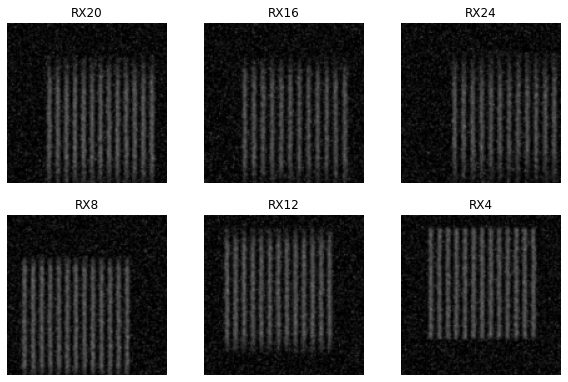

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Secondly, the images to be used for validation must be assigned.

In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

Found 3465 files belonging to 11 classes.
Using 693 files for validation.


Using data augmentation adds some more variety to the training data, thus resulting in a higher accuracy.

In [6]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(*img_size,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Standardizing the data.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Creating the model.

In [8]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compiling the model.

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                  

# Training the model.

In [10]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
44/44 [==============================] - 399s 3s/step - loss: 2.3079 - accuracy: 0.1183 - val_loss: 2.2234 - val_accuracy: 0.1198
Epoch 2/50
44/44 [==============================] - 50s 1s/step - loss: 2.0696 - accuracy: 0.2237 - val_loss: 1.9778 - val_accuracy: 0.1919
Epoch 3/50
44/44 [==============================] - 50s 1s/step - loss: 1.8255 - accuracy: 0.2933 - val_loss: 1.7631 - val_accuracy: 0.2843
Epoch 4/50
44/44 [==============================] - 50s 1s/step - loss: 1.5929 - accuracy: 0.3817 - val_loss: 2.8590 - val_accuracy: 0.1977
Epoch 5/50
44/44 [==============================] - 50s 1s/step - loss: 1.3940 - accuracy: 0.4286 - val_loss: 2.1155 - val_accuracy: 0.2612
Epoch 6/50
44/44 [==============================] - 51s 1s/step - loss: 1.2593 - accuracy: 0.4758 - val_loss: 1.5246 - val_accuracy: 0.3824
Epoch 7/50
44/44 [==============================] - 51s 1s/step - loss: 1.1615 - accuracy: 0.5159 - val_loss: 1.4868 - val_accuracy: 0.3550
Epoch 8/50
44/44 [=

Visualizing the training results.

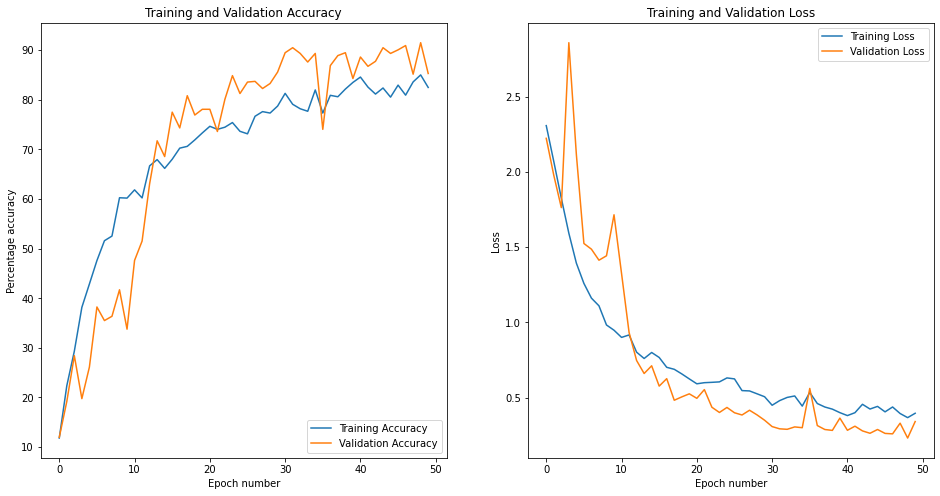

In [11]:
acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])

loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc * 100, label='Training Accuracy')
plt.plot(epochs_range, val_acc * 100, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epoch number")
plt.ylabel("Percentage accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.title('Training and Validation Loss')
plt.show()

# Predicting an image.

In [12]:
def predict_image(file_path, prediction_dict):
  img_path = os.path.join(data_dir, file_path)

  img = tf.keras.utils.load_img(
      img_path, target_size=img_size
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  temp_names = file_path.split("/")[-1].split()
  width, rx = temp_names[1], temp_names[2]
  actual = rx
  predicted = class_names[np.argmax(score)]
  confidence = 100 * np.max(score)

  print(
      "Actual: {} \t| Predicted: {} \t| Confidence: {:.2f}%"
      .format(actual, predicted, confidence)
  )

  if rx==predicted:
    prediction_dict[rx + " CORRECT"] += 1
  else:
    prediction_dict[rx + " INCORRECT"] += 1
    prediction_dict[rx + " DIF"] += abs(int(actual[2:]) - int(predicted[2:]))
  prediction_dict[rx + " CONFIDENCE"] += confidence

  return prediction_dict

In [13]:
prediction_files = os.path.join(direc, "Test", "Train")

predict_dictionary = {}

for i in class_names:
  predict_dictionary[i + " CORRECT"] = 0
  predict_dictionary[i + " INCORRECT"] = 0
  predict_dictionary[i + " CONFIDENCE"] = 0
  predict_dictionary[i + " DIF"] = 0

for folder in os.listdir(prediction_files):
  for file in os.listdir(os.path.join(prediction_files, folder)):
    file_path = os.path.join(prediction_files, folder, file)
    predict_dictionary = predict_image(file_path, predict_dictionary)

correct = []
incorrect = []
confidence = []
dif = []

for i in class_names:
  total = predict_dictionary[i + " CORRECT"] + predict_dictionary[i + " INCORRECT"]
  predict_dictionary[i + " CONFIDENCE"] /= total

  correct.append(100 * predict_dictionary[i + " CORRECT"] / total)
  incorrect.append(100 * predict_dictionary[i + " INCORRECT"] / total)
  if predict_dictionary[i + " INCORRECT"] > 0:
    dif.append(predict_dictionary[i + " DIF"] / predict_dictionary[i + " INCORRECT"])
  else:
    dif.append(0)
  confidence.append(predict_dictionary[i + " CONFIDENCE"])

Actual: RX12 	| Predicted: RX12 	| Confidence: 99.41%
Actual: RX12 	| Predicted: RX12 	| Confidence: 52.22%
Actual: RX12 	| Predicted: RX12 	| Confidence: 99.79%
Actual: RX12 	| Predicted: RX12 	| Confidence: 92.01%
Actual: RX12 	| Predicted: RX12 	| Confidence: 99.65%
Actual: RX12 	| Predicted: RX12 	| Confidence: 99.56%
Actual: RX12 	| Predicted: RX12 	| Confidence: 99.85%
Actual: RX12 	| Predicted: RX8 	| Confidence: 56.23%
Actual: RX12 	| Predicted: RX12 	| Confidence: 99.71%
Actual: RX12 	| Predicted: RX12 	| Confidence: 97.95%
Actual: RX12 	| Predicted: RX12 	| Confidence: 77.61%
Actual: RX12 	| Predicted: RX12 	| Confidence: 90.19%
Actual: RX12 	| Predicted: RX12 	| Confidence: 99.80%
Actual: RX12 	| Predicted: RX12 	| Confidence: 97.62%
Actual: RX12 	| Predicted: RX12 	| Confidence: 73.67%
Actual: RX12 	| Predicted: RX12 	| Confidence: 97.76%
Actual: RX12 	| Predicted: RX12 	| Confidence: 91.99%
Actual: RX12 	| Predicted: RX12 	| Confidence: 99.66%
Actual: RX12 	| Predicted: RX

Sorting the results in order of increasing angle.

In [14]:
order = []

for i in class_names:
  order.append(int(i[2:]))

order = np.argsort(order)
class_names = np.array(class_names)[order]
correct = np.array(correct)[order]
incorrect = np.array(incorrect)[order]
confidence = np.array(confidence)[order]
dif = np.array(dif)[order]

Visualising how accurately the model predicts rotations.

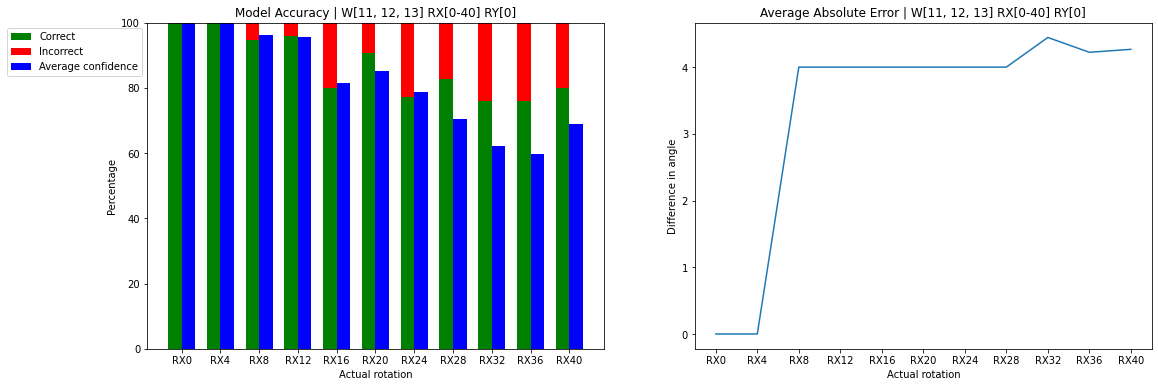

In [18]:
bar_width = 0.35 
x = np.arange(len(class_names))

plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.bar(x-bar_width/2, correct, bar_width, color="g", label='Correct')
plt.bar(x-bar_width/2, incorrect, bar_width, bottom=correct,
       color="r", label='Incorrect')
plt.bar(x+bar_width/2, confidence, bar_width, color="b", label="Average confidence")
plt.title("Model Accuracy | %s" % folder_name)
plt.xlabel("Actual rotation")
plt.xticks(x, class_names)
plt.ylabel("Percentage")
plt.legend(loc='upper right', bbox_to_anchor=(0, 1))

plt.subplot(122)
plt.plot(x, dif, label="Absolute difference")
plt.title("Model Accuracy | %s" % folder_name)
plt.xlabel("Actual rotation")
plt.xticks(x, class_names)
plt.ylabel("Difference in angle")
plt.title("Average Absolute Error | %s" % folder_name)
plt.show()